<a href="https://colab.research.google.com/github/PSergey24/jupyter_notebooks/blob/main/NBA_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [443]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn import tree

In [315]:
# franchises = {1: 'Atlanta Hawks', 2: 'Boston Celtics', 3: 'Brooklyn Nets', 4: 'Charlotte Hornets', 5: 'Chicago Bulls', 6: 'Cleveland Cavaliers', 7: 'Dallas Mavericks', 8: 'Denver Nuggets', 9: 'Detroit Pistons', 10: 'Golden State Warriors', 11: 'Houston Rockets', 12: 'Indiana Pacers', 13: 'Los Angeles Clippers', 14: 'Los Angeles Lakers', 15: 'Memphis Grizzlies', 16: 'Miami Heat', 17: 'Milwaukee Bucks', 18: 'Minnesota Timberwolves', 19: 'New Orleans Pelicans', 20: 'New York Knicks', 21: 'Oklahoma City Thunder', 22: 'Orlando Magic', 23: 'Philadelphia 76ers', 24: 'Phoenix Suns', 25: 'Portland Trail Blazers', 26: 'Sacramento Kings', 27: 'San Antonio Spurs', 28: 'Toronto Raptors', 29: 'Utah Jazz', 30: 'Washington Wizards', 31: 'Anderson Packers', 32: 'Baltimore Bullets', 33: 'Chicago Stags', 34: 'Cleveland Rebels', 35: 'Denver Nuggets', 36: 'Detroit Falcons', 37: 'Indianapolis Jets', 38: 'Indianapolis Olympians', 39: 'Kentucky Colonels', 40: 'Memphis Sounds', 41: 'Pittsburgh Condors', 42: 'Pittsburgh Ironmen', 43: 'Providence Steam Rollers', 44: 'San Diego Sails', 45: 'Sheboygan Red Skins', 46: 'Spirits of St. Louis', 47: 'St. Louis Bombers', 48: 'The Floridians', 49: 'Toronto Huskies', 50: 'Utah Stars', 51: 'Virginia Squires', 52: 'Washington Capitols', 53: 'Waterloo Hawks'}

In [723]:
franchises = {1: 'Atlanta Hawks', 2: 'Boston Celtics', 3: 'Brooklyn Nets', 4: 'Charlotte Hornets', 5: 'Chicago Bulls', 6: 'Cleveland Cavaliers', 7: 'Dallas Mavericks', 35: 'Denver Nuggets', 9: 'Detroit Pistons', 10: 'Golden State Warriors', 11: 'Houston Rockets', 12: 'Indiana Pacers', 13: 'Los Angeles Clippers', 14: 'Los Angeles Lakers', 15: 'Memphis Grizzlies', 16: 'Miami Heat', 17: 'Milwaukee Bucks', 18: 'Minnesota Timberwolves', 19: 'New Orleans Pelicans', 20: 'New York Knicks', 21: 'Oklahoma City Thunder', 22: 'Orlando Magic', 23: 'Philadelphia 76ers', 24: 'Phoenix Suns', 25: 'Portland Trail Blazers', 26: 'Sacramento Kings', 27: 'San Antonio Spurs', 28: 'Toronto Raptors', 29: 'Utah Jazz', 30: 'Washington Wizards', 31: 'Anderson Packers', 32: 'Baltimore Bullets', 33: 'Chicago Stags', 34: 'Cleveland Rebels', 36: 'Detroit Falcons', 37: 'Indianapolis Jets', 38: 'Indianapolis Olympians', 39: 'Kentucky Colonels', 40: 'Memphis Sounds', 41: 'Pittsburgh Condors', 42: 'Pittsburgh Ironmen', 43: 'Providence Steam Rollers', 44: 'San Diego Sails', 45: 'Sheboygan Red Skins', 46: 'Spirits of St. Louis', 47: 'St. Louis Bombers', 48: 'The Floridians', 49: 'Toronto Huskies', 50: 'Utah Stars', 51: 'Virginia Squires', 52: 'Washington Capitols', 53: 'Waterloo Hawks'}
def get_key(value):
    for k, v in franchises.items():
        if v == value:
            return k

def name_to_id(name):
  return get_key(name)

In [724]:
def union_data(df, df_odds):
  new_df = pd.merge(df, df_odds[['home_odd', 'visitor_odd', 'id_home', 'id_visitor', 'home_score','visitor_score']],  how='inner', left_on=['id_home', 'id_visitor', 'home_score','visitor_score'], right_on = ['id_home', 'id_visitor', 'home_score','visitor_score'])
  return new_df


In [725]:
def union_data_2(df_input):
  df_input = df_input.copy()
  df_input.reset_index(drop=True, inplace=True)
  df_input['visitor_odd'] = 'empty'
  df_input['home_odd'] = 'empty' 
  for i, row in df_input.iterrows():
      # print(df_input.loc[i, :])
      info_odds = odds[(odds['id_home'] == df_input.loc[i, :]['id_home']) & (odds['id_visitor'] == df_input.loc[i, :]['id_visitor']) & (odds['home_score'] == df_input.loc[i, :]['home_score']) & (odds['visitor_score'] == df_input.loc[i, :]['visitor_score'])]
      if len(info_odds) != 1:
        continue
      df_input.at[i, 'visitor_odd'] = float(info_odds.visitor_odd)
      df_input.at[i, 'home_odd'] = float(info_odds.home_odd)
  return df_input

In [726]:
df_all = pd.read_csv('drive/MyDrive/Colab Notebooks/data/dataset_9_6_2022.csv', sep=',')
odds = pd.read_csv('drive/MyDrive/Colab Notebooks/data/odds.csv', sep='\t', index_col = [0])

In [727]:
df_all.rename({'pts_visitor': 'visitor_score', 'pts_home': 'home_score'}, axis=1, inplace=True)

In [728]:
df = df_all[(df_all['season'] > 2000) & (df_all['season'] < 2017)]

In [729]:
df_validate = df_all[df_all['season'] > 2016]

In [730]:
df = df[df[['ELO_home', 't1p3_per', 't1p4_per', 't1p5_per', 't1p6_per', 't1p7_per', 't2p0_per', 't2p1_per', 't2p2_per', 't2p3_per', 't2p4_per', 't2p5_per', 't2p6_per', 't2p7_per']].notnull().all(1)]
df_validate = df_validate[df_validate[['ELO_home', 't1p3_per', 't1p4_per', 't1p5_per', 't1p6_per', 't1p7_per', 't2p0_per', 't2p1_per', 't2p2_per', 't2p3_per', 't2p4_per', 't2p5_per', 't2p6_per', 't2p7_per']].notnull().all(1)]
odds = odds.loc[(odds['home_odd'] != '-') & (odds['visitor_odd'] != '-')]
odds = odds.astype({"visitor_score": "Int64", "home_score": "Int64", "home_odd": "float32", "visitor_odd": "float32"})

In [731]:
odds['id_home'] = odds['home'].apply(lambda x: name_to_id(x))
odds['id_visitor'] = odds['visitor'].apply(lambda x: name_to_id(x))

In [732]:
# odds[odds['home'] == 'Denver Nuggets'].head(3)
odds.head(3)

,season,date,time,home,visitor,home_score,visitor_score,home_odd,visitor_odd,info,id_home,id_visitor
0,2017,12 Jun 2017,21:00,Golden State Warriors,Cleveland Cavaliers,129,120,1.26,4.19,NaN,10,6
1,2017,09 Jun 2017,21:00,Cleveland Cavaliers,Golden State Warriors,137,116,2.67,1.52,NaN,6,10
2,2017,07 Jun 2017,21:00,Cleveland Cavaliers,Golden State Warriors,113,118,2.39,1.64,NaN,6,10


In [733]:
# df_validate['visitor_odd'] = 'empty'
# df_validate['home_odd'] = 'empty'
df_validate.head(3)
# df_validate[df_validate['id_home'] == 35].head(3)

,id,link,date,season,visitor_score,home_score,id_visitor,id_home,ELO_visitor,ELO_home,...,t2p1_per,t2p2_per,t2p3_per,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y
32344,59392,https://www.basketball-reference.com/boxscores...,"Wed, Oct 26, 2016",2017,113,94,26,24,-0.206,-0.395,...,1.000,0.574,0.483,0.470,0.386,0.344,0.266,0,0,1
32348,59396,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,114,106,13,25,0.285,0.274,...,0.589,0.515,0.404,0.320,0.265,0.224,0.211,0,0,1
32349,59397,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,102,94,27,26,0.549,-0.089,...,0.529,0.463,0.413,0.403,0.389,0.359,0.246,0,1,1


In [734]:
df_full_validate = union_data_2(df_validate)

In [735]:
df_full_validate = df_full_validate[(df_full_validate['visitor_odd'] != 'empty') | (df_full_validate['home_odd'] != 'empty')]
df_full_validate

,id,link,date,season,visitor_score,home_score,id_visitor,id_home,ELO_visitor,ELO_home,...,t2p3_per,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y,visitor_odd,home_odd
0,59392,https://www.basketball-reference.com/boxscores...,"Wed, Oct 26, 2016",2017,113,94,26,24,-0.206,-0.395,...,0.483,0.470,0.386,0.344,0.266,0,0,1,2.36,1.69
1,59396,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,114,106,13,25,0.285,0.274,...,0.404,0.320,0.265,0.224,0.211,0,0,1,1.74,2.21
2,59397,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,102,94,27,26,0.549,-0.089,...,0.413,0.403,0.389,0.359,0.246,0,1,1,1.27,4.04
3,59398,https://www.basketball-reference.com/boxscores...,"Fri, Oct 28, 2016",2017,94,91,6,28,0.539,0.242,...,0.418,0.233,0.212,0.175,0.121,0,0,1,1.62,2.36
4,59399,https://www.basketball-reference.com/boxscores...,"Fri, Oct 28, 2016",2017,94,103,12,3,0.135,-0.413,...,0.485,0.361,0.336,0.292,0.237,0,0,0,1.45,3.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,66942,https://www.basketball-reference.com/boxscores...,"Thu, May 26, 2022",2022,110,120,7,10,0.329,0.447,...,0.578,0.463,0.358,0.344,0.333,0,0,0,3.26,1.37
7429,66943,https://www.basketball-reference.com/boxscores...,"Fri, May 27, 2022",2022,111,103,16,2,0.420,0.713,...,0.469,0.409,0.406,0.327,0.318,0,0,1,4.17,1.26
7430,66944,https://www.basketball-reference.com/boxscores...,"Sun, May 29, 2022",2022,100,96,2,16,0.647,0.486,...,0.390,0.272,0.204,0.195,0.161,0,0,1,1.68,2.27
7431,66945,https://www.basketball-reference.com/boxscores...,"Thu, Jun 2, 2022",2022,120,108,2,10,0.660,0.473,...,1.000,0.987,0.522,0.471,0.470,0,0,1,2.43,1.61


In [736]:
df_full_validate_2 = union_data(df_validate, odds)
df_full_validate_2

,id,link,date,season,visitor_score,home_score,id_visitor,id_home,ELO_visitor,ELO_home,...,t2p3_per,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y,home_odd,visitor_odd
0,59392,https://www.basketball-reference.com/boxscores...,"Wed, Oct 26, 2016",2017,113,94,26,24,-0.206,-0.395,...,0.483,0.470,0.386,0.344,0.266,0,0,1,1.69,2.36
1,59396,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,114,106,13,25,0.285,0.274,...,0.404,0.320,0.265,0.224,0.211,0,0,1,2.21,1.74
2,59397,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,102,94,27,26,0.549,-0.089,...,0.413,0.403,0.389,0.359,0.246,0,1,1,4.04,1.27
3,59398,https://www.basketball-reference.com/boxscores...,"Fri, Oct 28, 2016",2017,94,91,6,28,0.539,0.242,...,0.418,0.233,0.212,0.175,0.121,0,0,1,2.36,1.62
4,59399,https://www.basketball-reference.com/boxscores...,"Fri, Oct 28, 2016",2017,94,103,12,3,0.135,-0.413,...,0.485,0.361,0.336,0.292,0.237,0,0,0,3.01,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,66942,https://www.basketball-reference.com/boxscores...,"Thu, May 26, 2022",2022,110,120,7,10,0.329,0.447,...,0.578,0.463,0.358,0.344,0.333,0,0,0,1.37,3.26
7436,66943,https://www.basketball-reference.com/boxscores...,"Fri, May 27, 2022",2022,111,103,16,2,0.420,0.713,...,0.469,0.409,0.406,0.327,0.318,0,0,1,1.26,4.17
7437,66944,https://www.basketball-reference.com/boxscores...,"Sun, May 29, 2022",2022,100,96,2,16,0.647,0.486,...,0.390,0.272,0.204,0.195,0.161,0,0,1,2.27,1.68
7438,66945,https://www.basketball-reference.com/boxscores...,"Thu, Jun 2, 2022",2022,120,108,2,10,0.660,0.473,...,1.000,0.987,0.522,0.471,0.470,0,0,1,1.61,2.43


In [737]:
df_validate['id_home'].unique()

array([24, 25, 26, 28,  3,  9, 21, 16,  7, 29, 19, 23,  4,  6, 20, 27, 17,
        5, 35, 13, 11, 15,  1, 12, 18, 30,  2, 22, 10, 14])

In [738]:
df_validate['id_visitor'].unique()

array([26, 13, 27,  6, 12, 22, 24,  4, 11, 14, 10,  1,  2, 15, 19,  3, 25,
       18, 29, 17,  7, 30,  5, 35, 20, 23, 28,  9, 21, 16])

In [739]:
df_full_validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7368 entries, 0 to 7432
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7368 non-null   int64  
 1   link           7368 non-null   object 
 2   date           7368 non-null   object 
 3   season         7368 non-null   int64  
 4   visitor_score  7368 non-null   int64  
 5   home_score     7368 non-null   int64  
 6   id_visitor     7368 non-null   int64  
 7   id_home        7368 non-null   int64  
 8   ELO_visitor    7368 non-null   float64
 9   ELO_home       7368 non-null   float64
 10  t1p0_per       7368 non-null   float64
 11  t1p1_per       7368 non-null   float64
 12  t1p2_per       7368 non-null   float64
 13  t1p3_per       7368 non-null   float64
 14  t1p4_per       7368 non-null   float64
 15  t1p5_per       7368 non-null   float64
 16  t1p6_per       7368 non-null   float64
 17  t1p7_per       7368 non-null   float64
 18  t2p0_per

In [740]:
df_validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7433 entries, 32344 to 39898
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7433 non-null   int64  
 1   link           7433 non-null   object 
 2   date           7433 non-null   object 
 3   season         7433 non-null   int64  
 4   visitor_score  7433 non-null   int64  
 5   home_score     7433 non-null   int64  
 6   id_visitor     7433 non-null   int64  
 7   id_home        7433 non-null   int64  
 8   ELO_visitor    7433 non-null   float64
 9   ELO_home       7433 non-null   float64
 10  t1p0_per       7433 non-null   float64
 11  t1p1_per       7433 non-null   float64
 12  t1p2_per       7433 non-null   float64
 13  t1p3_per       7433 non-null   float64
 14  t1p4_per       7433 non-null   float64
 15  t1p5_per       7433 non-null   float64
 16  t1p6_per       7433 non-null   float64
 17  t1p7_per       7433 non-null   float64
 18  t2p

In [741]:
odds.head(3)

,season,date,time,home,visitor,home_score,visitor_score,home_odd,visitor_odd,info,id_home,id_visitor
0,2017,12 Jun 2017,21:00,Golden State Warriors,Cleveland Cavaliers,129,120,1.26,4.19,NaN,10,6
1,2017,09 Jun 2017,21:00,Cleveland Cavaliers,Golden State Warriors,137,116,2.67,1.52,NaN,6,10
2,2017,07 Jun 2017,21:00,Cleveland Cavaliers,Golden State Warriors,113,118,2.39,1.64,NaN,6,10


In [742]:
df_full_validate.head(3)

,id,link,date,season,visitor_score,home_score,id_visitor,id_home,ELO_visitor,ELO_home,...,t2p3_per,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y,visitor_odd,home_odd
0,59392,https://www.basketball-reference.com/boxscores...,"Wed, Oct 26, 2016",2017,113,94,26,24,-0.206,-0.395,...,0.483,0.470,0.386,0.344,0.266,0,0,1,2.36,1.69
1,59396,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,114,106,13,25,0.285,0.274,...,0.404,0.320,0.265,0.224,0.211,0,0,1,1.74,2.21
2,59397,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,102,94,27,26,0.549,-0.089,...,0.413,0.403,0.389,0.359,0.246,0,1,1,1.27,4.04


In [743]:
df = df.loc[:, 'ELO_visitor':]

In [744]:
train_df, test_df = train_test_split(df, test_size=2000)

In [745]:
train_df.head(3)

,ELO_visitor,ELO_home,t1p0_per,t1p1_per,t1p2_per,t1p3_per,t1p4_per,t1p5_per,t1p6_per,t1p7_per,...,t2p1_per,t2p2_per,t2p3_per,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y
18108,0.561,0.433,0.440,0.436,0.383,0.323,0.289,0.243,0.242,0.220,...,0.556,0.407,0.344,0.309,0.302,0.299,0.280,0,0,0
19305,-0.008,-0.328,0.570,0.374,0.352,0.345,0.270,0.200,0.197,0.188,...,0.273,0.231,0.194,0.182,0.163,0.121,0.109,1,1,0
21778,0.588,0.450,0.865,0.520,0.479,0.443,0.373,0.360,0.314,0.313,...,0.520,0.464,0.331,0.312,0.296,0.283,0.169,0,0,0


In [746]:
train_features = train_df.loc[:, 'ELO_visitor':'home_b2b']
Y = train_df.loc[:, 'Y']

In [747]:
model = LogisticRegression(random_state=0)
model.fit(train_features, Y)

LogisticRegression(random_state=0)

In [748]:
test_features = test_df.loc[:, 'ELO_visitor':'home_b2b']
test_Y = test_df.loc[:, 'Y']

In [749]:
model_pipeline = Pipeline(
    [
        ('model', LogisticRegression(random_state=0))
    ]
)

In [766]:
model_pipeline.fit(train_features, Y)

Pipeline(steps=[('model', LogisticRegression(random_state=0))])

In [767]:
precision_score(y_true=test_Y, y_pred=model_pipeline.predict(test_features))

0.6306818181818182

In [768]:
recall_score(y_true=test_Y, y_pred=model_pipeline.predict(test_features))

0.4220532319391635

In [769]:
prec, rec, thresholds = precision_recall_curve(y_true=test_Y, probas_pred=model_pipeline.predict_proba(test_features)[:, 1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


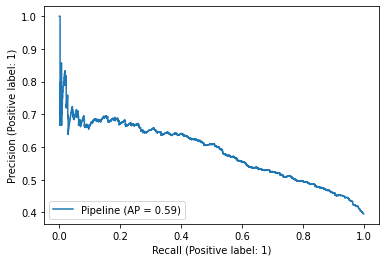

In [770]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_features, y=test_Y)

In [771]:
np.where(prec > 0.75)

(array([1964, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
        1980, 1986, 1987, 1988, 1991, 1992, 1993]),)

In [772]:
thresholds[1964]

0.7956561899256087

In [773]:
precision_score(y_true=test_Y, y_pred=model_pipeline.predict_proba(test_features)[:, 1] > thresholds[1964])

0.75

In [774]:
recall_score(y_true=test_Y, y_pred=model_pipeline.predict_proba(test_features)[:, 1] > thresholds[1964])

0.026615969581749048

In [775]:
grid_pipeline = Pipeline(
    [
        ('model', 
          GridSearchCV(
            LogisticRegression(random_state=0, max_iter=5000),
            param_grid={'C': [0.1, 1, 10.]},
            cv=3,
            verbose=4
            )
        )
    ]
)

In [776]:
grid_pipeline.fit(train_features, Y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.674 total time=   0.1s
[CV 2/3] END .............................C=0.1;, score=0.680 total time=   0.1s
[CV 3/3] END .............................C=0.1;, score=0.673 total time=   0.1s
[CV 1/3] END ...............................C=1;, score=0.672 total time=   0.3s
[CV 2/3] END ...............................C=1;, score=0.680 total time=   0.2s
[CV 3/3] END ...............................C=1;, score=0.671 total time=   0.2s
[CV 1/3] END ............................C=10.0;, score=0.671 total time=   0.2s
[CV 2/3] END ............................C=10.0;, score=0.680 total time=   0.3s
[CV 3/3] END ............................C=10.0;, score=0.671 total time=   0.3s


Pipeline(steps=[('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(max_iter=5000,
                                                           random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [783]:
def to_get_results(df_input, model_input, comment):
  df_input = df_input.copy()
  df_input.reset_index(drop=True, inplace=True)
  df_validate_features = df_input.loc[:, 'ELO_visitor':'home_b2b']
  df_validate_y = df_input.loc[:, 'Y']

  # active_thresholds = thresholds[1964]
  # active_thresholds = 0.5
  # predictions = model_pipeline.predict_proba(df_validate_features)[:, 1] > active_thresholds
  # predictions = model_pipeline.predict(df_validate_features)
  predictions = model_input.predict(df_validate_features)

  real_results = df_validate_y.tolist()

  bet_size = 100
  total_bet = 0
  total_win = 0

  step = []
  money = []
  current = 0

  good_precision = 0

  for i, prediction in enumerate(predictions):
    visitor_odd = df_input.loc[i, 'visitor_odd']
    home_odd = df_input.loc[i, 'home_odd']

    # print(f'step {i}: {real_results[i]}, {bool(real_results[i])}, {prediction}')

    if bool(real_results[i]) == prediction:
      if prediction is True:
        total_win += bet_size * float(visitor_odd)
        current += bet_size * float(visitor_odd)
        # print(f'WIN: {bet_size * float(visitor_odd)}')
      else:
        total_win += bet_size * float(home_odd)
        current += bet_size * float(home_odd)
        # print(f'WIN: {bet_size * float(home_odd)}')
      good_precision += 1

    # print(df_full_validate.loc[i])
    
    total_bet += bet_size
    current -= bet_size
    money.append(current)
    step.append(i)

  print(f'ROI = {total_win/total_bet}, accuracy = {good_precision / len(df_validate_y)}, count_bets = {total_bet/bet_size}, wins = {total_win}, bets = {total_bet}, cash = {total_win - total_bet}')

  plt.plot(step, money, label=comment)

  plt.legend()
  plt.xlabel('step')
  plt.ylabel('money')


In [599]:
# save csv
df_full_validate.to_csv('drive/MyDrive/Colab Notebooks/data/games_with_odds.csv', sep='\t', encoding='utf-8')

In [600]:
# save csv
df_full_validate[df_full_validate['season'] > 2016].to_csv('drive/MyDrive/Colab Notebooks/data/games_with_odds_2017.csv', sep='\t', encoding='utf-8')

ROI = 1.2897543425183342, accuracy = 0.6433224755700325, count_bets = 7368.0, wins = 950290.9995675087, bets = 736800, cash = 213490.9995675087


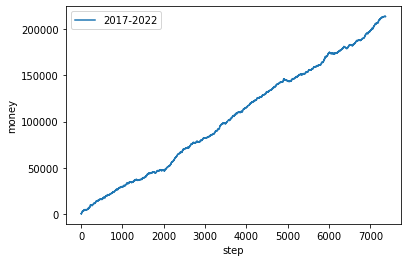

In [784]:
# linear regression, 2017-2022 seasons
to_get_results(df_full_validate, model_pipeline, '2017-2022')

ROI = 1.2791968494888366, accuracy = 0.6464566929133858, count_bets = 1270.0, wins = 162457.99988508224, bets = 127000, cash = 35457.999885082245
ROI = 1.280155642301656, accuracy = 0.6575875486381323, count_bets = 1285.0, wins = 164500.0000357628, bets = 128500, cash = 36000.00003576279
ROI = 1.3001247056275722, accuracy = 0.6547155105222136, count_bets = 1283.0, wins = 166805.99973201752, bets = 128300, cash = 38505.99973201752
ROI = 1.316271338929813, accuracy = 0.6531895777178796, count_bets = 1113.0, wins = 146501.00002288818, bets = 111300, cash = 35201.00002288818
ROI = 1.2507813870645177, accuracy = 0.6031606672519754, count_bets = 1139.0, wins = 142463.99998664856, bets = 113900, cash = 28563.99998664856
ROI = 1.3111267598208873, accuracy = 0.6416275430359938, count_bets = 1278.0, wins = 167561.9999051094, bets = 127800, cash = 39761.999905109406


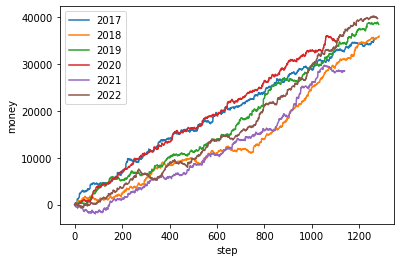

In [785]:
# linear regression
season = df_full_validate[df_full_validate['season'] == 2017]
to_get_results(season, model_pipeline, '2017')

season = df_full_validate[df_full_validate['season'] == 2018]
to_get_results(season, model_pipeline, '2018')

season = df_full_validate[df_full_validate['season'] == 2019]
to_get_results(season, model_pipeline, '2019')

season = df_full_validate[df_full_validate['season'] == 2020]
to_get_results(season, model_pipeline, '2020')

season = df_full_validate[df_full_validate['season'] == 2021]
to_get_results(season, model_pipeline, '2021')

season = df_full_validate[df_full_validate['season'] == 2022]
to_get_results(season, model_pipeline, '2022')

In [786]:
# decision trees, 2017-2022 seasons
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_features, Y)

ROI = 1.1611210633631508, accuracy = 0.5825190010857764, count_bets = 7368.0, wins = 855513.9994859695, bets = 736800, cash = 118713.99948596954


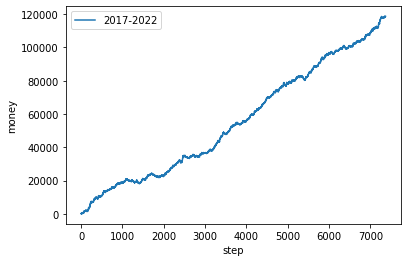

In [787]:
# decision trees
to_get_results(df_full_validate, clf, '2017-2022')

ROI = 1.1533307087703013, accuracy = 0.5874015748031496, count_bets = 1270.0, wins = 146473.00001382828, bets = 127000, cash = 19473.000013828278
ROI = 1.1133696498573986, accuracy = 0.5797665369649806, count_bets = 1285.0, wins = 143068.00000667572, bets = 128500, cash = 14568.00000667572
ROI = 1.1551208088199143, accuracy = 0.5853468433359315, count_bets = 1283.0, wins = 148201.999771595, bets = 128300, cash = 19901.999771595
ROI = 1.2085804134901856, accuracy = 0.6001796945193172, count_bets = 1113.0, wins = 134515.00002145767, bets = 111300, cash = 23215.000021457672
ROI = 1.1675065836433365, accuracy = 0.5610184372256365, count_bets = 1139.0, wins = 132978.999876976, bets = 113900, cash = 19078.999876976013
ROI = 1.175876367726423, accuracy = 0.581377151799687, count_bets = 1278.0, wins = 150276.99979543686, bets = 127800, cash = 22476.99979543686


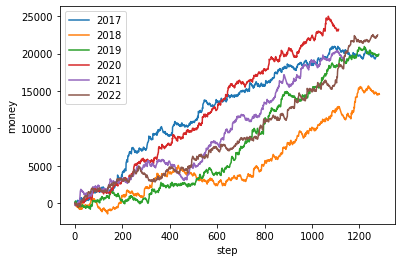

In [788]:
season = df_full_validate[df_full_validate['season'] == 2017]
to_get_results(season, clf, '2017')

season = df_full_validate[df_full_validate['season'] == 2018]
to_get_results(season, clf, '2018')

season = df_full_validate[df_full_validate['season'] == 2019]
to_get_results(season, clf, '2019')

season = df_full_validate[df_full_validate['season'] == 2020]
to_get_results(season, clf, '2020')

season = df_full_validate[df_full_validate['season'] == 2021]
to_get_results(season, clf, '2021')

season = df_full_validate[df_full_validate['season'] == 2022]
to_get_results(season, clf, '2022')